### Train Your PyTorch Model

Let’s dive into learning by doing! In this notebook, we’ll walk through creating an image classifier to detect different types of playing cards. To tackle this problem, we’ll break down the process into three essential parts:

1. **PyTorch Dataset**  
2. **PyTorch Model**  
3. **PyTorch Training Loop**  

This three-part approach is a common pattern in PyTorch model training pipelines and provides a solid structure for tackling machine learning projects.

### Why These Three Steps?

Nearly every PyTorch model training pipeline follows this paradigm. Each step serves a critical role in the training process:

### 1. PyTorch Dataset
   - Before a model can learn from data, we need to organize the data and labels in a structured format. The dataset class handles this by:
     - Loading data from a specified source (e.g., images from a folder).
     - Applying transformations (e.g., resizing, normalization) to make the data compatible with the model’s input requirements.
     - Ensuring each data item is correctly paired with its label, enabling the model to understand what it’s learning.
   - Additionally, by wrapping the dataset in a PyTorch `DataLoader`, we automate batching and shuffling, making training more efficient and preventing overfitting.

### 2. PyTorch Model
   - Here, we define the architecture of the neural network. This could be a simple convolutional neural network (CNN) for image data or a more complex model.
   - PyTorch provides flexibility in designing custom architectures, allowing us to specify the number of layers, neurons, activation functions, and other details.
   - A well-designed model architecture will help extract meaningful patterns from the dataset, which is essential for achieving high accuracy in classification tasks.

### 3. PyTorch Training Loop
   - The training loop is where learning happens. It consists of the steps required to teach the model by feeding it data, calculating predictions, and adjusting weights based on errors.
   - During each epoch (a full pass over the dataset), the training loop:
     - Passes data batches through the model to get predictions.
     - Calculates the loss (a measure of prediction error).
     - Backpropagates the loss to adjust model weights, improving accuracy over time.
     - Tracks progress, showing how well the model is learning.
   - By iterating through this loop, we train the model to minimize error and improve its ability to recognize playing cards.

### Summary
Following these steps allows us to build a complete and efficient model training pipeline in PyTorch, ensuring that each phase—data handling, model definition, and training—contributes to high-quality model performance. By structuring our project this way, we’ll create a classifier that can reliably detect and identify different playing cards.

In [1]:
# Core PyTorch and Model Building Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import timm
from torch.optim.lr_scheduler import StepLR

# Data Handling and Augmentation Libraries
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image

# Visualization and Utility Libraries
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import random

## Step 1: PyTorch Dataset (and DataLoader)

Would you try to bake a cake without first gathering the ingredients? Probably not. The same idea applies to training a PyTorch model—you need to set up the dataset correctly first to ensure everything flows smoothly. 

### Why Datasets Are Important

Datasets are crucial because they provide a structured way to organize and load data, along with corresponding labels, into the model. Here’s why setting up a dataset properly is essential:

- **Organized Data Handling**: A well-defined dataset class organizes how data and labels are loaded, transforming raw data into a format that the model can easily process.

- **Efficient Training with DataLoader**: Wrapping the dataset in a DataLoader allows PyTorch to handle important tasks automatically, such as:
  - **Batching**: Splitting data into manageable chunks for each training step, which speeds up the process and improves memory efficiency.
  - **Shuffling**: Randomly mixing the data each epoch, which prevents the model from learning in a specific order and helps generalize better.
  
With a correctly set up Dataset and DataLoader, we’re prepared to feed data into our model efficiently, ensuring it learns from the data in a structured, effective way.


In [2]:
class PlayingCardDataset(Dataset):
    """
    A custom dataset class for loading playing card images from a directory.

    Args:
        data_dir (str): The path to the dataset directory containing images organized in subfolders.
        transform (callable, optional): A function/transform to apply to the images (e.g., data augmentation, normalization).

    Attributes:
        data (ImageFolder): A torchvision ImageFolder dataset object.
        transform (callable): A transform to be applied to the images during data loading.
    """

    def __init__(self, data_dir, transform=None):
        """
        Initializes the dataset by loading images from the given directory using ImageFolder.

        Args:
            data_dir (str): Path to the root directory containing the dataset.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        # Initialize the dataset using ImageFolder from torchvision
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        """
        Returns the total number of images in the dataset.
        
        Returns:
            int: Number of images in the dataset.
        """
        return len(self.data)
    
    def __getitem__(self, idx):
        """
        Fetches the image and its label by index.

        Args:
            idx (int): The index of the image to retrieve.

        Returns:
            tuple: (image, label) where image is a tensor and label is an integer.
        """
        return self.data[idx]

    @property
    def classes(self):
        """
        Returns the list of class labels.

        Returns:
            list: List of class names.
        """
        return self.data.classes

    @property
    def class_to_idx(self):
        """
        Returns the class-to-index mapping.

        Returns:
            dict: A dictionary mapping class names to indices.
        """
        return self.data.class_to_idx

    @property
    def img_size(self):
        """
        Returns the size of the images in the dataset.

        Returns:
            tuple: (width, height) of the images.
        """
        # Try getting image size from the first image in the dataset
        try:
            image_path, _ = self.data.imgs[0]
            with Image.open(image_path) as img:
                return img.size  # Returns (width, height)
        except Exception as e:
            print("Could not retrieve image size:", e)
            return None

In [3]:
data_dir = '/kaggle/input/cards-image-datasetclassification/train'
# Get a dictionary asocaiting target values with folder names
target_to_classes = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
target_to_classes

{0: 'ace of clubs',
 1: 'ace of diamonds',
 2: 'ace of hearts',
 3: 'ace of spades',
 4: 'eight of clubs',
 5: 'eight of diamonds',
 6: 'eight of hearts',
 7: 'eight of spades',
 8: 'five of clubs',
 9: 'five of diamonds',
 10: 'five of hearts',
 11: 'five of spades',
 12: 'four of clubs',
 13: 'four of diamonds',
 14: 'four of hearts',
 15: 'four of spades',
 16: 'jack of clubs',
 17: 'jack of diamonds',
 18: 'jack of hearts',
 19: 'jack of spades',
 20: 'joker',
 21: 'king of clubs',
 22: 'king of diamonds',
 23: 'king of hearts',
 24: 'king of spades',
 25: 'nine of clubs',
 26: 'nine of diamonds',
 27: 'nine of hearts',
 28: 'nine of spades',
 29: 'queen of clubs',
 30: 'queen of diamonds',
 31: 'queen of hearts',
 32: 'queen of spades',
 33: 'seven of clubs',
 34: 'seven of diamonds',
 35: 'seven of hearts',
 36: 'seven of spades',
 37: 'six of clubs',
 38: 'six of diamonds',
 39: 'six of hearts',
 40: 'six of spades',
 41: 'ten of clubs',
 42: 'ten of diamonds',
 43: 'ten of hear

In [4]:
# Define a set of transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128 pixels
    transforms.ToTensor()           # Convert images to PyTorch tensors
])

# Instantiate the PlayingCardDataset with the specified data directory and transformations
dataset = PlayingCardDataset(data_dir, transform)

In [5]:
# Retrieve an image and its label from the dataset at the specified index (100 in this case)
image, label = dataset[100]

# Check the shape of the retrieved image tensor
image_shape = image.shape
image_shape
# Output the shape of the image tensor to understand its dimensions
# Expected output format: torch.Size([C, H, W])
# - C: Number of channels (3 for RGB images)
# - H: Height of the image (128 pixels, as specified in the Resize transform)
# - W: Width of the image (128 pixels, as specified in the Resize transform)

torch.Size([3, 128, 128])

### DataLoaders in PyTorch

In deep learning workflows, efficient data handling is crucial to optimize training and evaluation phases. The `DataLoader` class in PyTorch simplifies this process by managing data batching, shuffling, and parallel loading, allowing for smoother, more efficient model training.

### Setting Up the DataLoader

To load data in manageable chunks, or *batches*, we use the `DataLoader` class. Batching data speeds up training and helps the model generalize better by exposing it to varying data patterns within each epoch. Here’s a breakdown of key components:

- **`dataset`**: This refers to the dataset instance (e.g., `PlayingCardDataset`) which includes both images and labels.
- **`batch_size`**: Defines how many samples to load per batch. For instance, `batch_size=32` means 32 images and labels will be processed together in each iteration.
- **`shuffle`**: If `True`, the dataset is randomly shuffled at each epoch. Shuffling helps prevent the model from learning the data order and improves generalization.

In [6]:
# Create a DataLoader to efficiently load data in batches during training or evaluation
# - `dataset`: The PlayingCardDataset instance containing images and labels
# - `batch_size=32`: Specifies the number of samples to load per batch; in this case, 32 images and labels will be loaded in each iteration
# - `shuffle=True`: Randomly shuffles the order of samples at each epoch, which helps in preventing the model from memorizing the data order and improves generalization
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [7]:
# Assuming `dataloader` is a DataLoader object, and we're iterating through images and labels

# Iterate through the DataLoader (one batch at a time)
for images, labels in dataloader:
    # Optional: Break the loop early for debugging or testing purposes (if needed)
    # This can be used to fetch only the first batch or limit the dataset iteration
    break

    # Example processing code:
    # Move images and labels to the GPU if available
    images, labels = images.to(device), labels.to(device)

# Example: Checking the size of the batch
print(f'Batch size: {images.size(0)}, Image shape: {images.shape}, Labels shape: {labels.shape}')
    
# Further processing (e.g., model inference or training) can be done here
# outputs = model(images)
# loss = criterion(outputs, labels)

Batch size: 32, Image shape: torch.Size([32, 3, 128, 128]), Labels shape: torch.Size([32])


## Step 2: PyTorch Model

Just as PyTorch datasets provide a structured way to organize your data, PyTorch models offer a clear framework for defining and organizing neural network architectures. In this step, we’ll set up our model for classifying playing cards.

### Building the Model: From Scratch or Pre-Trained

In PyTorch, you have two main options for creating a model:

1. **Define Each Layer from Scratch**: For a highly customized model, we can define each layer manually. This approach is flexible but can be time-intensive, as it requires carefully specifying layer types, sizes, activation functions, and more.
   
2. **Use Pre-Trained Models**: For tasks like image classification, where many state-of-the-art architectures already exist, we can use pre-trained models. Libraries like `timm` (Torch Image Models) offer numerous high-performance models, such as ResNet, EfficientNet, and Vision Transformers, which are already trained on large datasets like ImageNet.

   By starting with a pre-trained model, we leverage a powerful, well-optimized architecture and only need to make minor adjustments for our specific classification task.

### Customizing the Final Layer

The key to adapting a pre-trained model for a specific task is understanding the data flow through each layer, especially the shape and transformation of the data. Typically, only the final layer requires modification, as it needs to match the number of classes in your dataset.

For this playing card classifier, we’re classifying 52 cards across 4 suits, so we have 52 * 4 (208) target classes. This requires modifying the model’s last layer to output 208 classes instead of the default number of classes in the pre-trained model. 

### Key Points for Understanding and Modifying the Model

- **Data Flow Shape**: Understanding the data shape at each layer is crucial, as it ensures each layer is compatible with the next. Pre-trained models expect data in a specific format (e.g., 224x224 images for ResNet), so we adjust our input data accordingly.
- **Final Layer Adjustment**: We replace the final layer of the pre-trained model with a new layer that matches the number of target classes. In PyTorch, this often involves replacing the `fc` (fully connected) layer in models like ResNet or `classifier` in EfficientNet with a new layer that outputs the correct number of classes.

### Summary

By using a pre-trained model and modifying the final layer, we save time and benefit from cutting-edge architecture while customizing the model for our specific task. This approach makes it easier to achieve high accuracy in image classification, as we’re starting from a model that already understands general visual features and only needs slight adjustments for our playing card dataset.

![EfficientNet size and performance on the ImageNet dataset](http://miro.medium.com/v2/resize:fit:1400/format:webp/1*Inu_zWY2VSZulVuat0Hbwg.png)

In [8]:
class SimpleCardClassifier(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardClassifier, self).__init__()
        # Load pre-trained EfficientNet-B0 model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        
        # Extract the features from EfficientNet-B0 (excluding the classification layer)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        
        # Get the output size of the features before classification
        enet_out_size = 1280  # EfficientNet-B0 output features size
        
        # Define the final classification layer
        self.classifier = nn.Sequential(
            nn.Flatten(),               # Flatten the features to (batch_size, 1280)
            nn.Linear(enet_out_size, num_classes)  # Final output layer
        )
    
    def forward(self, x):
        # Pass through feature extractor (EfficientNet-B0)
        x = self.features(x)
        
        # Pass the extracted features through the classifier
        output = self.classifier(x)
        
        return output

## Step 3: The Training Loop

Now that we understand the basics of handling datasets and defining models in PyTorch, the next step is to create the training process for our model. The training loop is central to optimizing our model's performance and ensuring it learns to make accurate predictions.

### Key Considerations in the Training Process

1. **Data Splitting**: 
   - To properly evaluate our model's performance, we need to validate it on data it hasn't seen during training. 
   - Typically, we split the dataset into two parts: **training** and **validation**. This split allows us to monitor how well the model generalizes to unseen data, reducing the risk of overfitting.

2. **Terminology**:
   - **Epoch**: An epoch is one complete pass through the entire training dataset.
   - **Step**: A step refers to a single batch of data processed by the model in one iteration of training.

3. **Training Process**:
   - The training loop involves loading data into the model in batches, calculating the loss, and updating the model's parameters via backpropagation.
   - While there are libraries that handle this process automatically, writing the training loop manually at least once helps deepen your understanding of how models learn and optimize.

### Steps to Set Up the Training Loop

1. **Define an Optimizer**:
   - The optimizer updates the model's parameters to minimize the loss. A popular choice is the **Adam optimizer**, which is often effective for many tasks due to its adaptive learning rate.

2. **Define a Loss Function**:
   - The loss function measures how far the model's predictions are from the actual values, providing feedback for the model to improve.
   - The loss function is the target metric that the optimizer will work to minimize.

### Training Loop Code Structure

Below is an outline of a typical PyTorch training loop:

1. **Load Data**: Load a batch of data from the DataLoader.
2. **Forward Pass**: Pass the batch through the model to get predictions.
3. **Compute Loss**: Calculate the loss by comparing the model's predictions to the true labels.
4. **Backward Pass (Backpropagation)**: Compute gradients for each parameter with respect to the loss.
5. **Optimization Step**: Use the optimizer to update the model parameters based on the gradients.

In [9]:
# Set device (GPU if available)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [10]:
# Define the model
model = SimpleCardClassifier(num_classes=53)
model.to(device)

# Data transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalization
])

# Dataset setup (assuming PlayingCardDataset class is already defined)
train_dataset = PlayingCardDataset('/kaggle/input/cards-image-datasetclassification/train', transform=transform)
val_dataset = PlayingCardDataset('/kaggle/input/cards-image-datasetclassification/valid', transform=transform)
test_dataset = PlayingCardDataset('/kaggle/input/cards-image-datasetclassification/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)  # Added num_workers for parallel data loading
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

### Learning Rate Scheduler in PyTorch

A **learning rate scheduler** is a tool that adjusts the learning rate during training in a systematic way. Instead of using a fixed learning rate throughout the entire training process, a scheduler helps in gradually increasing or decreasing the learning rate based on certain conditions or predefined rules. This adjustment helps the model converge more efficiently and avoids overshooting or getting stuck in local minima.

### Why Use a Learning Rate Scheduler?

1. **Faster Convergence**: By reducing the learning rate during training, you can allow the model to make smaller updates as it gets closer to the optimal solution, improving convergence.
2. **Avoid Overshooting**: High learning rates may cause the model to "overshoot" the optimal solution. A scheduler can prevent this by gradually lowering the learning rate.
3. **Improved Generalization**: Some schedulers encourage better generalization by reducing the learning rate as the model starts to converge, which helps the model avoid overfitting.

### Common Learning Rate Scheduling Strategies

1. **StepLR**:
   - Reduces the learning rate by a factor (`gamma`) after a certain number of epochs (`step_size`).
   - Example: Decrease the learning rate by 30% every 5 epochs.

2. **CosineAnnealingLR**:
   - Decays the learning rate following a cosine function. This provides a smooth, gradual reduction in learning rate.
   - Typically used when the model's convergence behavior suggests a gradual slow-down is beneficial.

3. **ReduceLROnPlateau**:
   - Reduces the learning rate when the validation loss stops improving. It is often used when training with a validation dataset.
   - The learning rate is reduced by a factor (`factor`) when the monitored metric (e.g., validation loss) doesn't improve for a certain number of epochs (`patience`).

4. **ExponentialLR**:
   - Multiplies the learning rate by a constant factor (`gamma`) after each epoch.
   - Useful when you want a smooth exponential decay.

### How a Learning Rate Scheduler Works

- **Initialize Scheduler**: First, you define a scheduler and link it to the optimizer. For example, with `StepLR`, you set how often the learning rate should be adjusted (every `step_size` epochs) and by how much (`gamma`).
  
- **Step During Training**: After each epoch (or some other defined frequency), you call the `scheduler.step()` method to update the learning rate.

- **Adjust Learning Rate**: Based on the selected strategy, the scheduler will either reduce or increase the learning rate. Some strategies reduce the learning rate by a fixed factor, while others use more complex rules like cosine annealing or validation performance monitoring.

### Key Points to Remember:
- **Learning Rate Decay**: Schedulers help decrease the learning rate over time to enable fine-tuned adjustments as the model approaches optimal weights.
- **Dynamic Adjustment**: Schedulers allow dynamic adjustment based on predefined rules or metrics like validation loss.
- **Avoid Overfitting**: By controlling the rate of change in the weights, schedulers help the model avoid overfitting while learning more effectively.

### Types of Learning Rate Schedulers
- **Constant Learning Rate**: No scheduler is used, and the learning rate remains the same throughout training.
- **Scheduled Learning Rate**: The learning rate is dynamically adjusted during training using a defined strategy (e.g., StepLR, CosineAnnealingLR).
- **Adaptive Learning Rate**: Techniques like **ReduceLROnPlateau** adjust the learning rate based on how the model’s performance (e.g., validation loss) evolves.

By using a learning rate scheduler, you can optimize the training process, ensure more stable convergence, and improve model performance.


In [11]:
# Hyperparameters
num_epochs = 50
batch_size = 32
initial_lr = 0.01  # Initial learning rate
weight_decay = 1e-5  # Weight decay for regularization

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=initial_lr, weight_decay=weight_decay)

# Learning rate scheduler (StepLR example)
# Step size of 1 means it reduces the learning rate every epoch, and gamma of 0.7 means the learning rate is reduced by 30%
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

In [12]:
# Training loop with learning rate scheduler
train_losses, val_losses = [], []  # Lists to store training and validation losses across epochs

# Start training over multiple epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Display tqdm only every 5 epochs
    if (epoch + 1) % 10 == 0:
        train_desc = f'Epoch {epoch+1}/{num_epochs} - Training'
        val_desc = 'Validation Loop'
    else:
        train_desc = ''
        val_desc = ''

    for images, labels in tqdm(train_loader, desc=train_desc, disable=train_desc == ''):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * labels.size(0)

    # Compute average training loss for this epoch
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=val_desc, disable=val_desc == ''):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)

    # Compute average validation loss for this epoch
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    # Print the training and validation losses every 5 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}')

    # Step the learning rate scheduler at the end of each epoch
    scheduler.step()

Epoch 10/50 - Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/50 - Train Loss: 0.1660 - Validation Loss: 0.2277


Epoch 20/50 - Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 20/50 - Train Loss: 0.0652 - Validation Loss: 0.1901


Epoch 30/50 - Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 30/50 - Train Loss: 0.0641 - Validation Loss: 0.2067


Epoch 40/50 - Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 40/50 - Train Loss: 0.0591 - Validation Loss: 0.2508


Epoch 50/50 - Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 50/50 - Train Loss: 0.0606 - Validation Loss: 0.2488


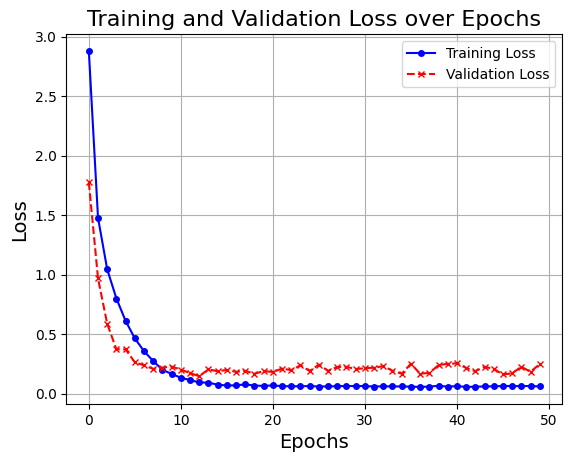

In [13]:
# Plot training and validation loss
plt.plot(train_losses, label='Training Loss', color='blue', linestyle='-', marker='o', markersize=4)
plt.plot(val_losses, label='Validation Loss', color='red', linestyle='--', marker='x', markersize=4)

# Add title and labels
plt.title('Training and Validation Loss over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Show legend
plt.legend()

# Add grid for better readability
plt.grid(True)

# Optionally, set a range for the y-axis for clarity (if you know the expected loss range)
# plt.ylim(0, 2)  # Adjust according to your loss scale

# Show plot
plt.show()

### Evaluating The Result

When evaluating a model, it is essential to assess how well it performs on unseen data, such as a test set. One of the best ways to do this is by predicting the class of random images and comparing the predicted classes with the true classes. Additionally, visualizing the model's confidence in its predictions can help gain insight into how it makes decisions.

Here’s an overview of the evaluation process:

#### 1. **Image Loading and Preprocessing**
The first step in evaluating the model is to load and preprocess the image. This involves reading the image file, converting it to the appropriate format (e.g., RGB), and applying any necessary transformations like resizing. The transformations ensure that the images are in a format suitable for the model's input.

#### 2. **Prediction Function**
Once the image is preprocessed, the next step is to make predictions. The model is set to evaluation mode, and the image is passed through it to obtain the output. The output is a set of probabilities for each class, which is then processed into a more interpretable format (e.g., sorted probabilities).

#### 3. **Visualization of Results**
After obtaining the probabilities for each class, it’s important to visualize the top-k predicted classes. This helps in understanding the model's confidence level for the most likely classes. The image is displayed alongside a bar plot of the top-k classes with their corresponding probabilities. This visualization can help you quickly assess whether the model is confident and correct in its predictions.

#### 4. **Selecting Random Test Images**
To evaluate the model on a variety of images, random images are selected from the test dataset. This ensures that the model's performance is not biased toward any particular class or type of image.

#### 5. **Making Predictions on Multiple Images**
The model is then used to make predictions on multiple random images. For each image, the actual class and the predicted class are displayed. This allows you to compare how well the model generalizes to different types of data, which is critical for assessing the model's real-world performance.

#### 6. **Output**
The results are presented in a human-readable format, showing the actual and predicted classes for each image. By comparing the predictions with the true labels, you can assess the model’s performance and identify any potential weaknesses. This also allows you to determine if the model is overfitting or underperforming on certain classes.

---

By following this approach, you can gain valuable insights into how well your model is performing and where improvements might be necessary.

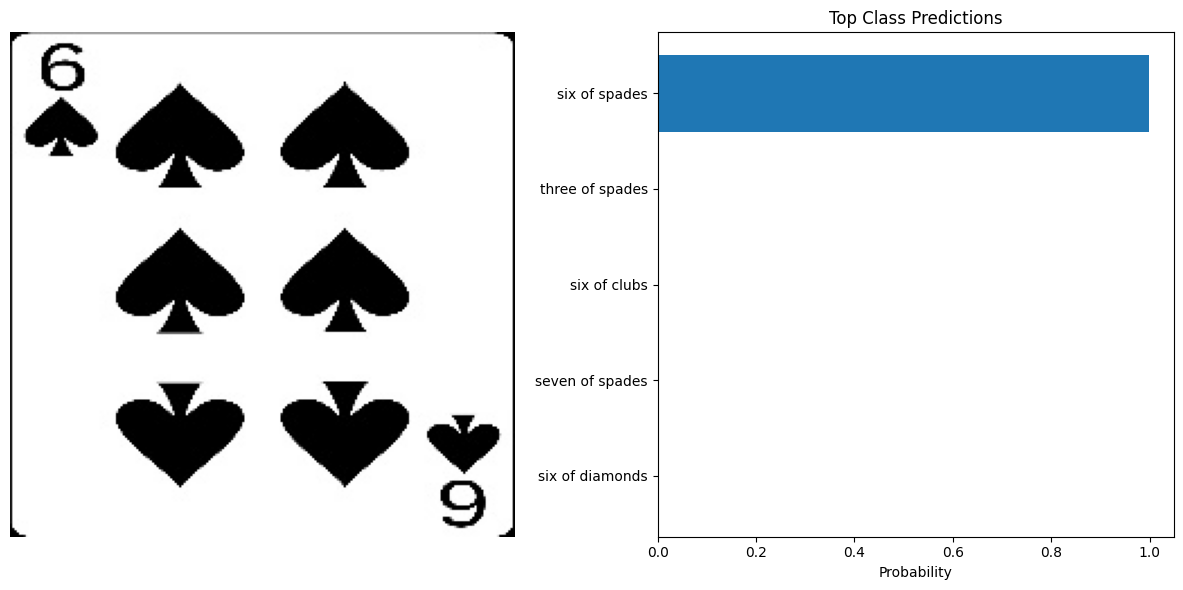

Image 1:
  Actual class: six of spades
  Predicted class: six of spades
------------------------------


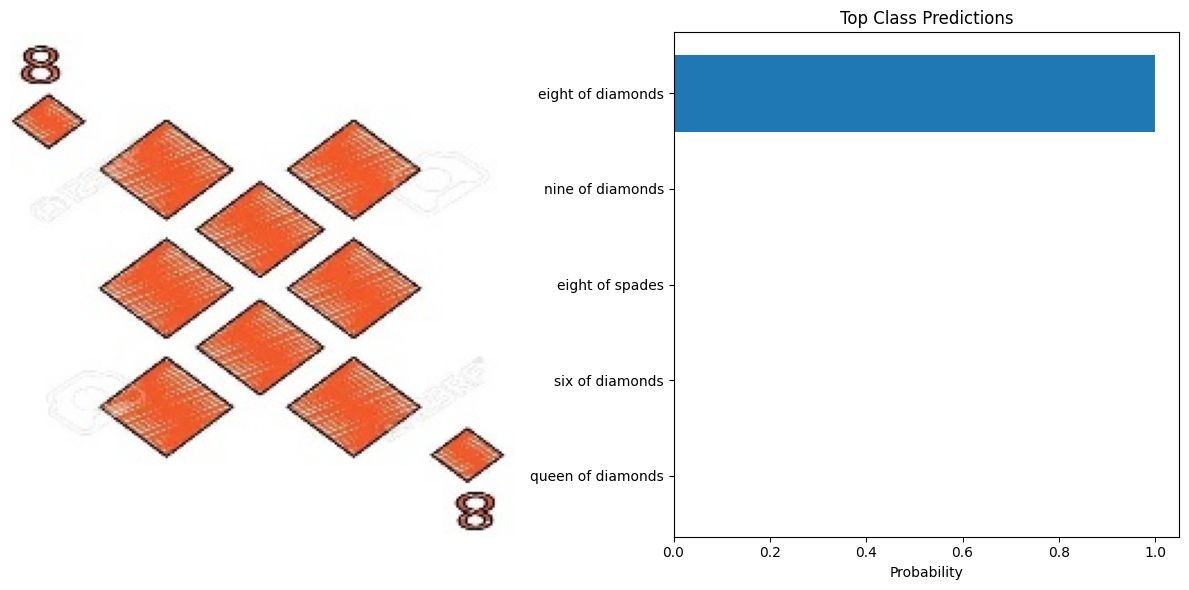

Image 2:
  Actual class: eight of diamonds
  Predicted class: eight of diamonds
------------------------------


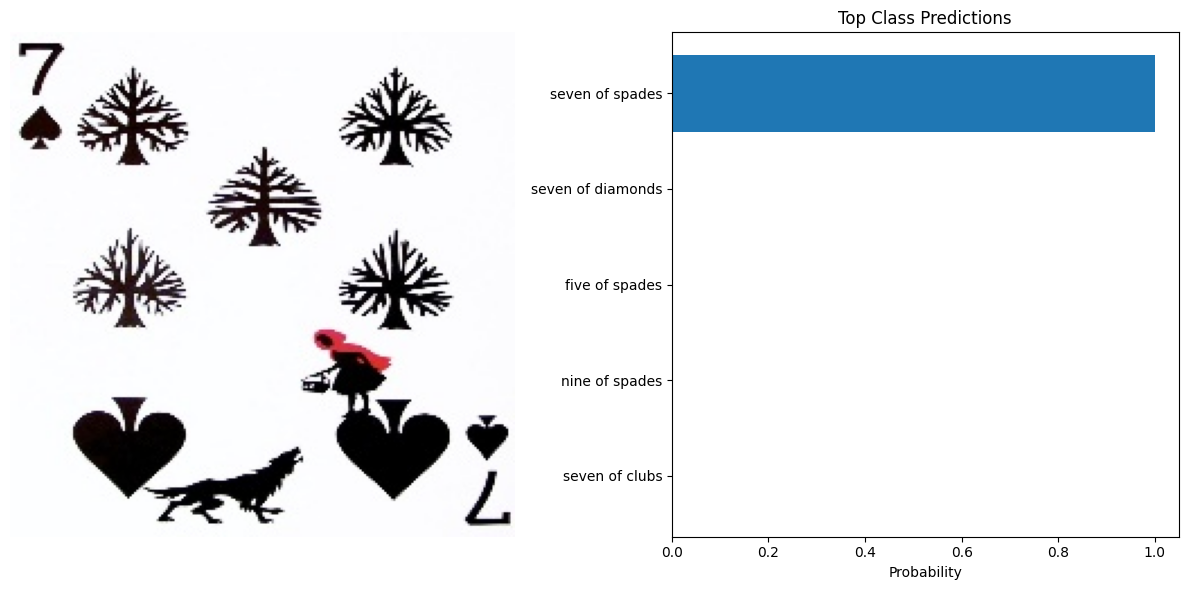

Image 3:
  Actual class: seven of spades
  Predicted class: seven of spades
------------------------------


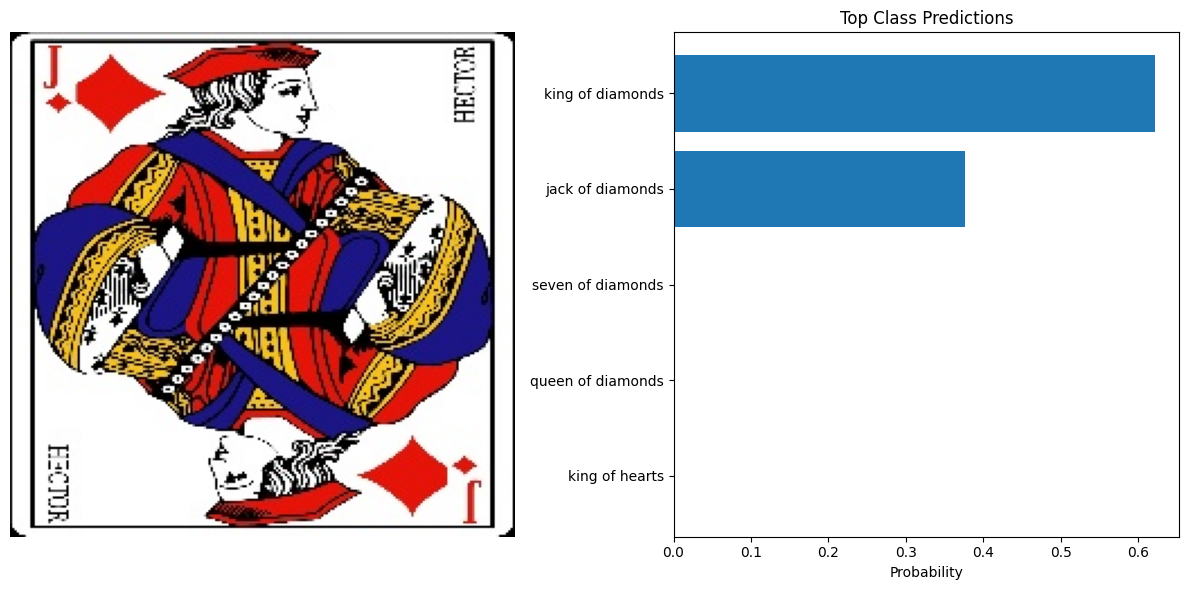

Image 4:
  Actual class: jack of diamonds
  Predicted class: king of diamonds
------------------------------


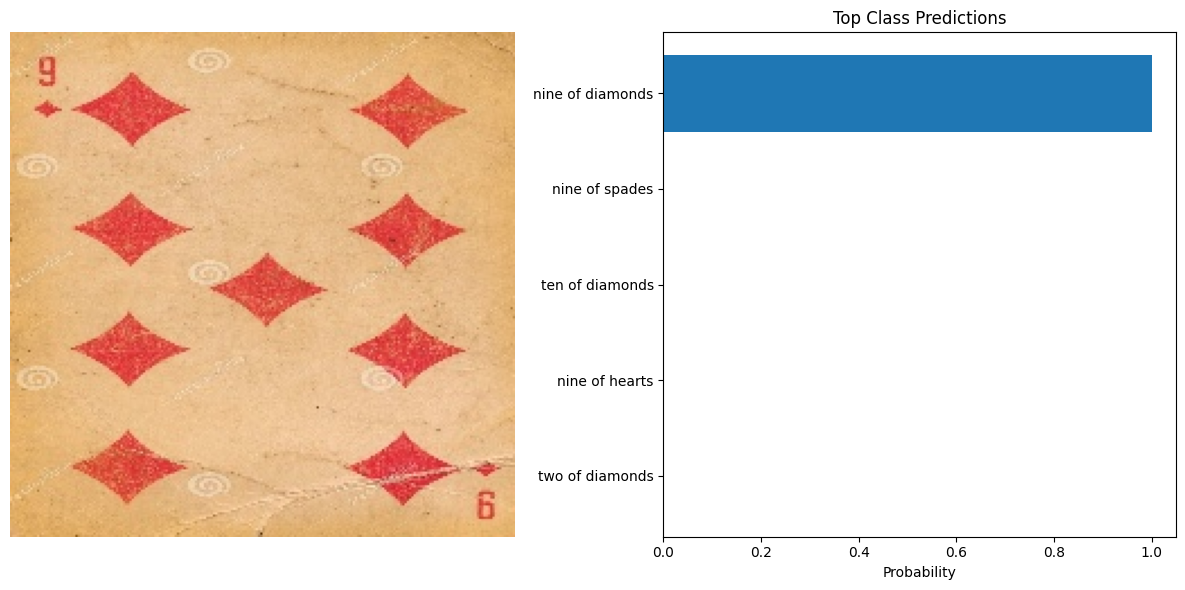

Image 5:
  Actual class: nine of diamonds
  Predicted class: nine of diamonds
------------------------------


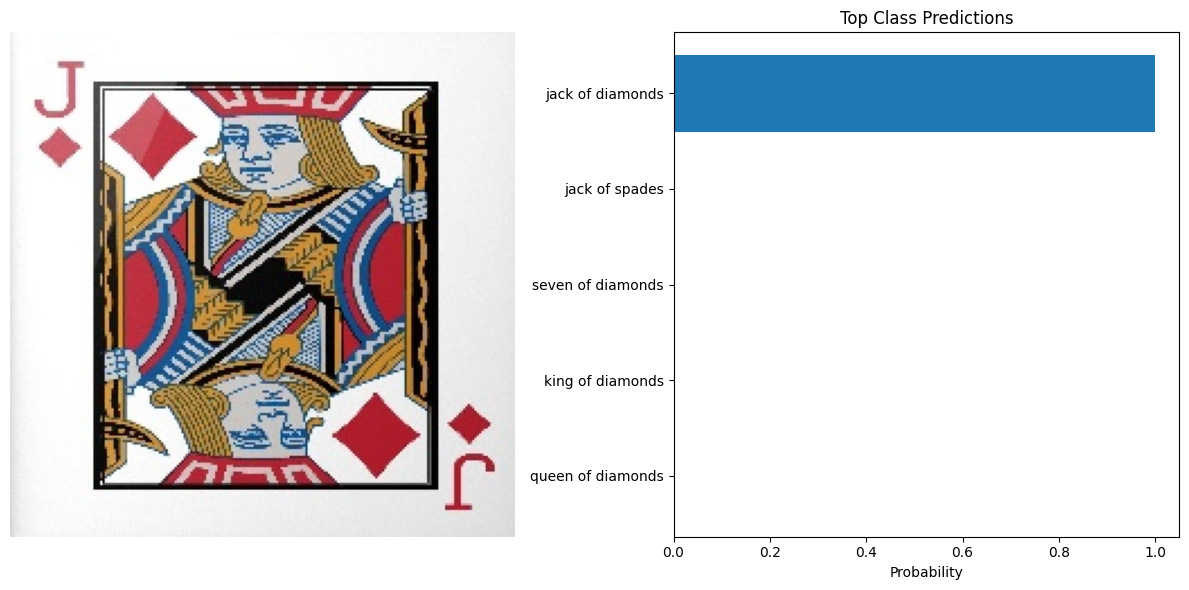

Image 6:
  Actual class: jack of diamonds
  Predicted class: jack of diamonds
------------------------------


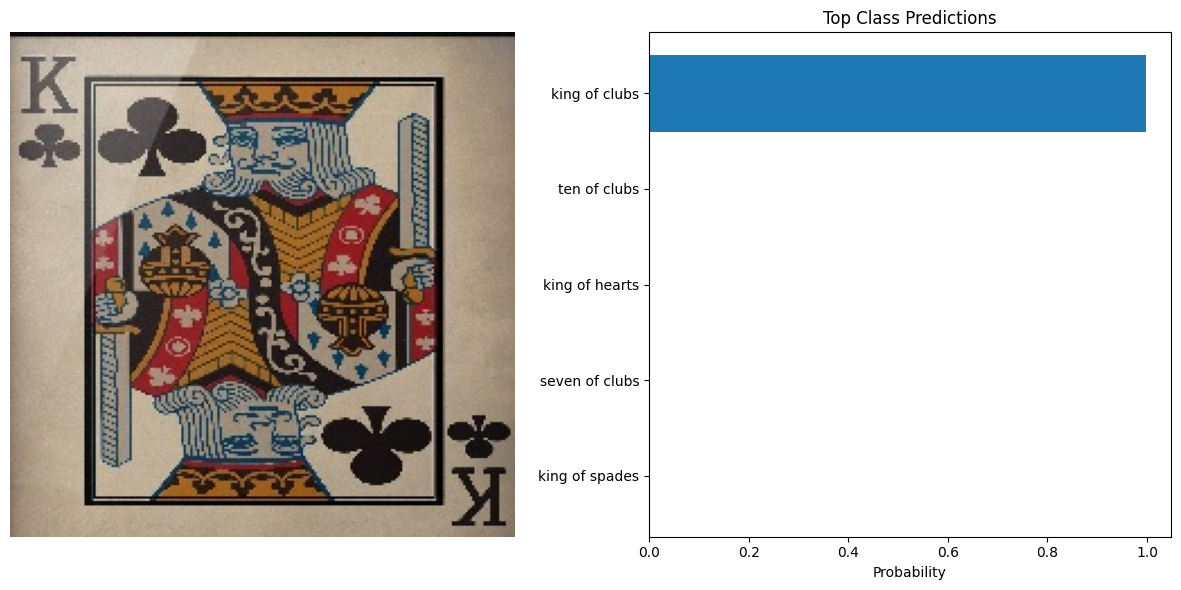

Image 7:
  Actual class: king of clubs
  Predicted class: king of clubs
------------------------------


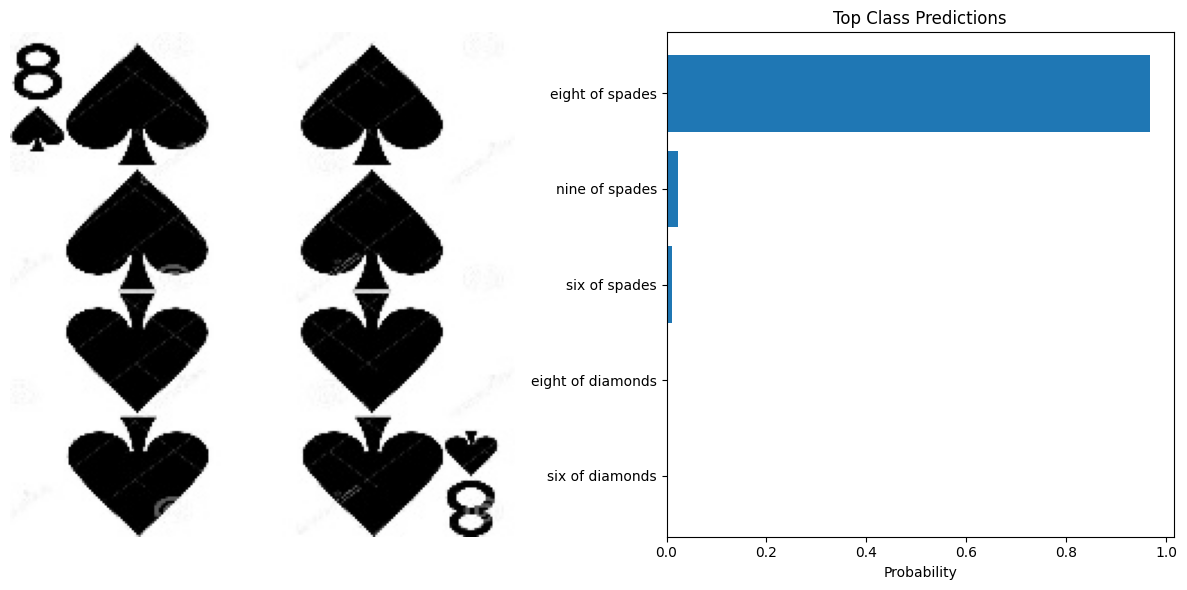

Image 8:
  Actual class: eight of spades
  Predicted class: eight of spades
------------------------------


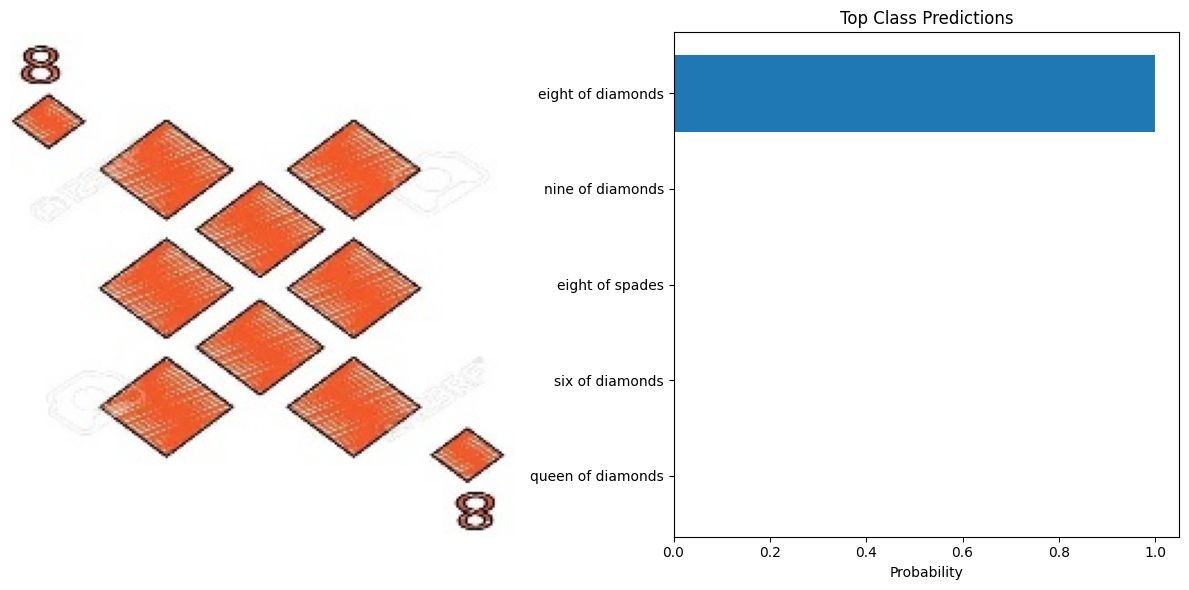

Image 9:
  Actual class: eight of diamonds
  Predicted class: eight of diamonds
------------------------------


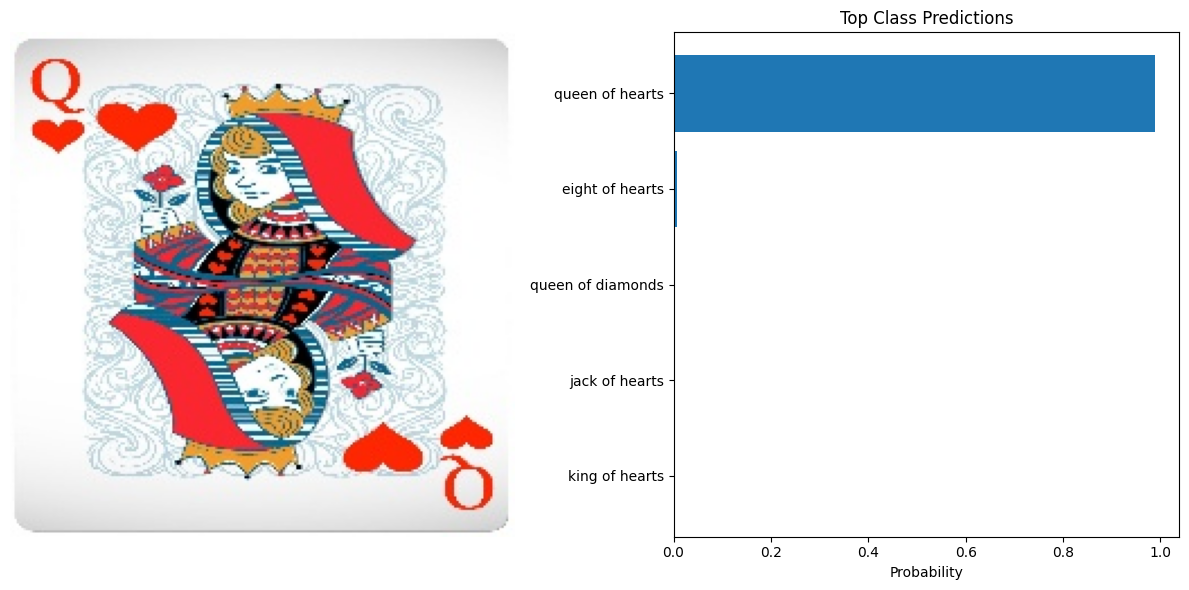

Image 10:
  Actual class: queen of hearts
  Predicted class: queen of hearts
------------------------------


In [14]:
# Combined image loading and preprocessing
def load_and_preprocess_image(image_path, transform):
    """
    Loads an image from the specified path, converts it to RGB format, applies transformations, 
    and prepares it as a tensor for model input.
    
    Args:
        image_path (str): The file path of the image to load.
        transform (torchvision.transforms.Compose): Transformations to apply to the image (e.g., resizing, normalization).
        
    Returns:
        tuple: Original PIL image and preprocessed image tensor ready for model input.
    """
    image = Image.open(image_path).convert("RGB")  # Open and convert image to RGB
    return image, transform(image).unsqueeze(0)     # Apply transformations and add batch dimension


# Prediction function with combined loading, preprocessing, and prediction
def predict_image(model, image_path, transform, device):
    """
    Loads and preprocesses an image, then uses the model to predict class probabilities.
    
    Args:
        model (torch.nn.Module): Trained model to use for prediction.
        image_path (str): Path to the image file to predict.
        transform (torchvision.transforms.Compose): Transformations to apply to the image.
        device (torch.device): Device to run the model on (CPU or GPU).
        
    Returns:
        tuple: Original image and class probabilities as a numpy array.
    """
    original_image, image_tensor = load_and_preprocess_image(image_path, transform)  # Load and preprocess image
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for inference
        image_tensor = image_tensor.to(device)  # Move image tensor to specified device
        outputs = model(image_tensor)           # Get model outputs
        probabilities = F.softmax(outputs, dim=1)  # Apply softmax to get class probabilities
    
    return original_image, probabilities.cpu().numpy().flatten()  # Return image and probabilities


# Visualization function
def visualize_predictions(image, probabilities, class_names, top_k=5):
    """
    Displays the original image alongside a bar chart of the top-k class predictions.
    
    Args:
        image (PIL.Image): The original image.
        probabilities (np.array): Array of class probabilities output by the model.
        class_names (list): List of class names corresponding to model output.
        top_k (int): Number of top predictions to display (default is 5).
    """
    top_k_idx = probabilities.argsort()[-top_k:][::-1]         # Get indices of top-k predictions
    top_classes = [class_names[i] for i in top_k_idx]          # Retrieve class names for top-k predictions
    top_probabilities = probabilities[top_k_idx]               # Get probabilities for top-k predictions

    # Plotting the original image and top-k predictions
    fig, axarr = plt.subplots(1, 2, figsize=(12, 6))
    axarr[0].imshow(image)                                     # Display the original image
    axarr[0].axis("off")
    
    axarr[1].barh(top_classes, top_probabilities)              # Display bar chart for top-k predictions
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Top Class Predictions")
    axarr[1].invert_yaxis()                                    # Display highest probability at the top
    
    plt.tight_layout()
    plt.show()


# Function to select a random image from the test folder
def get_random_image_from_folder(folder_path):
    """
    Selects a random image from a specified folder structure where images are organized by class.
    
    Args:
        folder_path (str): Path to the root folder containing subfolders for each class.
        
    Returns:
        tuple: File path to a randomly selected image and the actual class label.
    """
    classes = os.listdir(folder_path)                          # List all class subfolders in the test folder
    random_class = random.choice(classes)                      # Choose a random class
    class_folder = os.path.join(folder_path, random_class)     # Path to chosen class folder
    image_files = os.listdir(class_folder)                     # List all images in the chosen class folder
    random_image_file = random.choice(image_files)             # Choose a random image from the class folder
    return os.path.join(class_folder, random_image_file), random_class  # Return image path and class


# Example usage to predict and visualize 10 random images
test_folder_path = "/kaggle/input/cards-image-datasetclassification/test"
transform = transforms.Compose([
    transforms.Resize((128, 128)),    # Resize images to 128x128 pixels
    transforms.ToTensor()             # Convert images to PyTorch tensors
])

class_names = dataset.classes         # Assuming dataset.classes provides the class names

# Loop to predict on 10 random images and visualize results
for i in range(10):  
    test_image_path, actual_class = get_random_image_from_folder(test_folder_path)  # Select random image
    original_image, probabilities = predict_image(model, test_image_path, transform, device)  # Make prediction
    visualize_predictions(original_image, probabilities, class_names)  # Visualize top predictions
    
    # Print actual and predicted class
    predicted_class_idx = probabilities.argmax()
    predicted_class = class_names[predicted_class_idx]
    print(f"Image {i+1}:")
    print(f"  Actual class: {actual_class}")
    print(f"  Predicted class: {predicted_class}")
    print("-" * 30)

### Calculate the Accuracy of Our Model on the Test Set

After training a model, evaluating its performance on unseen data is crucial for understanding how well it generalizes. Here’s an explanation of how to calculate the model’s accuracy on a test set:

1. **Set the Model to Evaluation Mode**  
   Before starting evaluation, we set the model to evaluation mode, which disables features like dropout and batch normalization updates, ensuring that the model behaves consistently for inference. This step helps get accurate, stable results on test data.

2. **Initialize Counters for Correct and Total Predictions**  
   Two counters are used:
   - `correct_predictions` to count the number of images correctly classified by the model.
   - `total_predictions` to track the total number of images processed.
   These counters will be used to calculate the accuracy as the ratio of correct predictions to the total predictions.

3. **Iterate Through the Test Data**  
   Using a DataLoader, we process images in batches. Each batch is passed through the model to get predictions. Both images and labels are moved to the designated device (e.g., GPU or CPU) to ensure compatibility with the model.

4. **Make Predictions and Update Counters**  
   For each batch:
   - We obtain the model’s output for each image, which contains the predicted probabilities for each class.
   - We identify the class with the highest probability, which represents the model’s predicted label.
   - The number of correct predictions in each batch is counted by comparing the predicted labels with the actual labels. This value is added to the `correct_predictions` counter.
   - The batch size (total images in the batch) is added to `total_predictions`.

5. **Calculate Accuracy**  
   After iterating through the entire test set, the accuracy is calculated as:
   \[
   \text{Accuracy} = \left(\frac{\text{correct predictions}}{\text{total predictions}}\right) \times 100
   \]
   This gives the percentage of correctly classified images out of the total images in the test set.

6. **Output the Result**  
   Finally, the calculated accuracy is printed to provide a summary of the model’s performance on the test data. For example, an output of "Accuracy on the test set: 90.57%" means the model correctly classified 90.57% of the images in the test set.

By following this process, we obtain a clear measure of how well the model generalizes to unseen data, a critical indicator of its real-world applicability.


In [15]:
# Function to calculate accuracy on the test set
def calculate_accuracy(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in test_loader:
            # Move data to device (GPU or CPU)
            images, labels = images.to(device), labels.to(device)
            
            # Get predictions
            outputs = model(images)
            _, predicted_labels = torch.max(outputs, 1)  # Get the index of the max log-probability
            
            # Update correct predictions count
            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.size(0)  # Add batch size to total predictions
    
    # Calculate accuracy
    accuracy = 100 * correct_predictions / total_predictions
    return accuracy

# Assuming `test_loader` is your DataLoader for the test set
accuracy = calculate_accuracy(model, test_loader, device)
print(f'Accuracy on the test set: {accuracy:.2f}%')

Accuracy on the test set: 94.34%
